In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import scipy.ndimage as ndi 

In [2]:
# Define paths to your train, validation, and test directories
train_dir = '/Users/chamidiperera/Documents/Care/careBackEnd/Eye & Skin/train'
validation_dir = '/Users/chamidiperera/Documents/Care/careBackEnd/Eye & Skin/valid'
test_dir = '/Users/chamidiperera/Documents/Care/careBackEnd/Eye & Skin/test'

In [3]:
# Create ImageDataGenerators for loading and augmenting images during training
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Flow from directory for training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 2212 images belonging to 2 classes.


In [5]:
# Flow from directory for validation data
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 322 images belonging to 2 classes.


In [6]:
# Flow from directory for test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 364 images belonging to 2 classes.


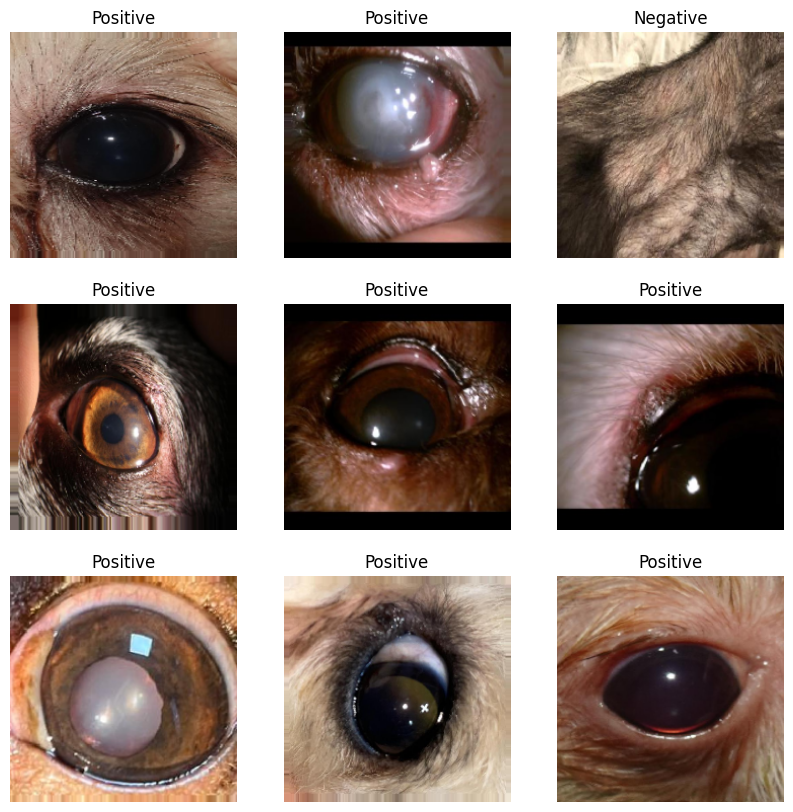

In [7]:
# Visualize some images from the training set
batch = train_generator.next()  # Get a batch of images and labels
images, labels = batch[0], batch[1]

label_names = ['Negative', 'Positive']  # Corresponding labels for 0 and 1

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    
    # Convert numerical label to string label
    label = label_names[int(labels[i][0])]  # Access the first element of labels[i]
    
    plt.title(label)
    plt.axis("off")
plt.show()


In [8]:
# Build the model (using MobileNetV2 as a base)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Use early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [10]:
# Train the model
history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[early_stop])

Epoch 1/20
70/70 [==============================] - 21s 285ms/step - loss: 0.1833 - accuracy: 0.9313 - val_loss: 0.0500 - val_accuracy: 0.9783
Epoch 2/20
70/70 [==============================] - 20s 279ms/step - loss: 0.0258 - accuracy: 0.9905 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 3/20
70/70 [==============================] - 21s 300ms/step - loss: 0.0144 - accuracy: 0.9941 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 4/20
70/70 [==============================] - 23s 320ms/step - loss: 0.0251 - accuracy: 0.9928 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 5/20
70/70 [==============================] - 23s 328ms/step - loss: 0.0166 - accuracy: 0.9928 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 6/20
70/70 [==============================] - 24s 336ms/step - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.0105 - val_accuracy: 0.9969
Epoch 7/20
70/70 [==============================] - 24s 339ms/step - loss: 0.0100 - accuracy: 0.9955 - val_loss: 0.0095 - val_accuracy: 0.9969

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

12/12 [==============================] - 3s 208ms/step - loss: 0.0032 - accuracy: 1.0000
Test Accuracy: 1.0


In [12]:
# Save the model
model.save('MobileNetV2_multi_detect.h5')

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


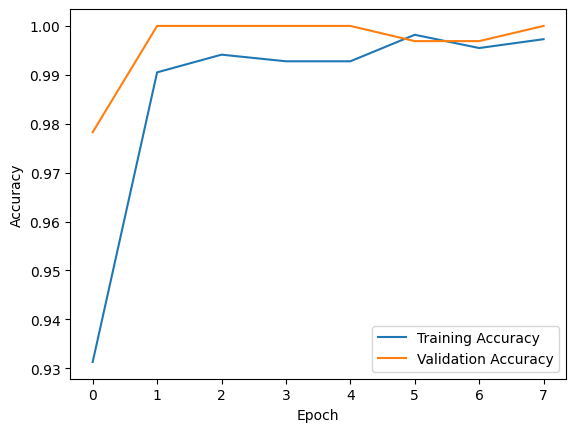

In [13]:
# Visualize training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()